In [2]:
"""
This script calculates a technical fair value of the S&P 500 at any given moment.

The fair value is calculated by applying linear regression on a historical window of SPY (S&P 500 ETF) data.
This script calculates the optimal window length for the linear regression by maximizing the returns of an
investment strategy over the last 10 years as described below. The optimal window looks to be 4 years.

This script simulates and evaluates an investment strategy on historical SPY (S&P 500 ETF) data.
It compares two approaches to investing:

1. A baseline (un-arbitraged) strategy where a fixed nominal amount is invested into the SPY index at each
   time step.
2. An adjusted strategy where the investment amount is scaled based on a "fair value" estimate
   of the stock's future price, obtained by applying linear regression on a sliding historical window.

For the adjusted strategy, the code:
  - Varies the lookback window length (from 0.1 up to 10 years, in 0.1-year increments).
  - Computes the fair value as the linear regression forecast of the price at the end of the window.
  - Uses the ratio of this fair value to the current price to adjust a nominal investment.

The performance of each strategy is measured by the ratio of the final portfolio value 
(total shares held multiplied by the final price) to the total money invested.
"""

'\nThis script simulates and evaluates an investment strategy on historical SPY (S&P 500 ETF) data.\nIt compares two approaches to investing:\n\n1. A baseline (un-arbitraged) strategy where a fixed nominal amount is invested into the SPY index at each\n   time step.\n2. An adjusted strategy where the investment amount is scaled based on a "fair value" estimate\n   of the stock\'s future price, obtained by applying linear regression on a sliding historical window.\n\nFor the adjusted strategy, the code:\n  - Varies the lookback window length (from 0.1 up to 10 years, in 0.1-year increments).\n  - Computes the fair value as the linear regression forecast of the price at the end of the window.\n  - Uses the ratio of this fair value to the current price to adjust a nominal investment.\n\nThe performance of each strategy is measured by the ratio of the final portfolio value \n(total shares held multiplied by the final price) to the total money invested.\nThis analysis can help in understand

In [11]:
from scipy import stats

import matplotlib.pyplot as plt
import yfinance as yf

In [12]:
spy = yf.Ticker("SPY")
TRADING_DAYS_PER_YEAR = 252

In [26]:
prices = list(spy.history(period="max")["Close"])
year_window = 4
time_window = TRADING_DAYS_PER_YEAR*year_window

x = [i for i in range(time_window)]
fair_value_prices = []
for i in range(len(prices) - time_window):
    prices_current = prices[i:i+time_window]
    slope, intercept, _, _, _ = stats.linregress(x, prices_current)
    fair_value_prices.append(slope*time_window + intercept)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


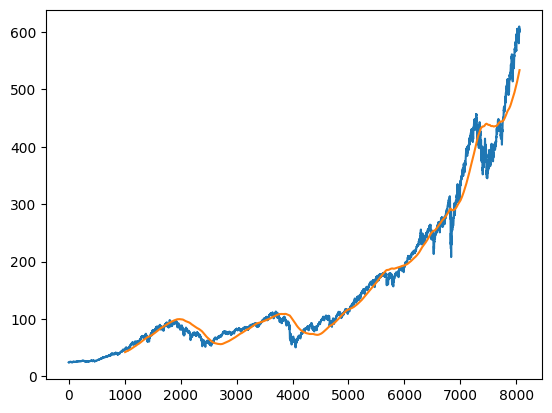

In [27]:
plt.plot(prices)
plt.plot([i for i in range(time_window, len(prices))], fair_value_prices)

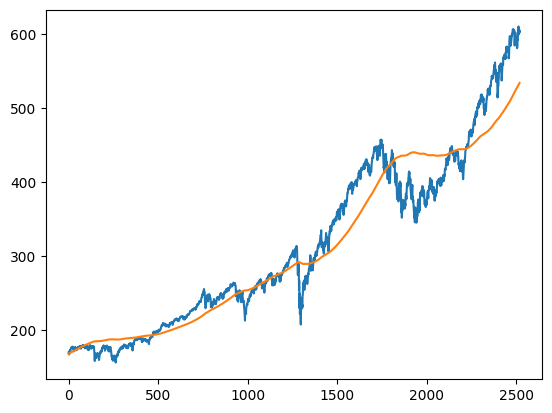

In [28]:
plt.plot(prices[-TRADING_DAYS_PER_YEAR*10:])
plt.plot(fair_value_prices[-TRADING_DAYS_PER_YEAR*10:])

In [20]:
def get_total_profit(prices, fair_value_prices, time_window, use_unarbitraged=False, return_window=len(prices)-(TRADING_DAYS_PER_YEAR*10)):
    price_payed = 0
    shares_bought = 0
    
    for i in range(return_window, len(prices)):
        price_to_pay = 10
        if not use_unarbitraged:
            price_to_pay = 10*fair_value_prices[i - time_window]/prices[i]
        price_payed += price_to_pay
        shares_bought += price_to_pay/prices[i]

    return (shares_bought * prices[-1]) - price_payed

In [ ]:
prices = list(spy.history(period="max")["Close"])
max_years = 20
window = TRADING_DAYS_PER_YEAR*max_years + 1
returns = [get_total_profit(prices, None, 0, True)]

for year_window in range(1, 12*max_years + 1):
    month_window = year_window/12
    print(month_window)
    time_window = int(TRADING_DAYS_PER_YEAR*month_window)
    
    x = [i for i in range(time_window)]
    fair_value_prices = []
    for i in range(len(prices) - time_window):
        prices_current = prices[i:i+time_window]
        slope, intercept, _, _, _ = stats.linregress(x, prices_current)
        fair_value_prices.append(slope*time_window + intercept)

    returns.append(get_total_profit(prices, fair_value_prices, time_window))

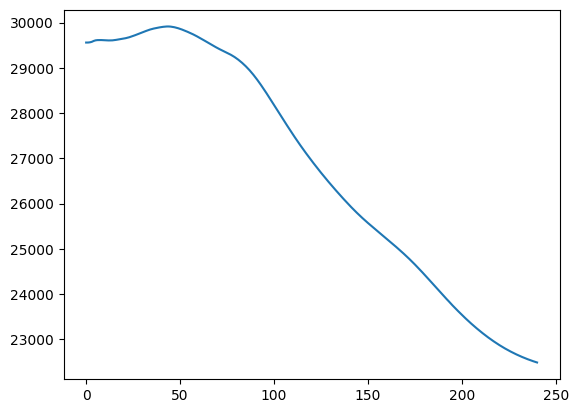

In [23]:
plt.plot(returns)